In [197]:
import math
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [129]:
img = cv2.imread("Bitmaps/test.png")
rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


In [130]:
def show_image(img, size=6):
    fig = plt.figure(figsize=(size, size))
    ax = fig.add_subplot(111)
    ax.imshow(img)
    plt.show()

In [155]:
def gauss_mask(img, min_delta=10, kernel_size=3, all_below=50):
    """Returns pixels which are darker than their neighbors."""
    blur = cv2.GaussianBlur(gray, (kernel_size, kernel_size), cv2.BORDER_CONSTANT)
    diff = cv2.subtract(blur, img)
    ret, mask = cv2.threshold(diff, min_delta, 255, cv2.THRESH_BINARY)
    # add back large areas of very dark pixels
    ret, dark = cv2.threshold(img, thresh=all_below, maxval=255, type=cv2.THRESH_BINARY_INV)
    # show_image(cv2.subtract(dark, mask), size=4)
    return mask
    # return cv2.bitwise_or(dark, mask)

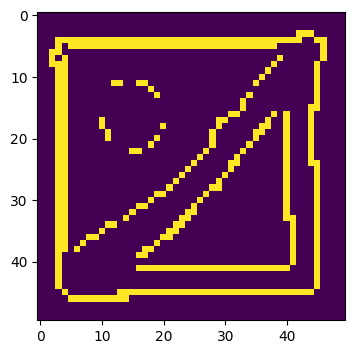

In [173]:
mask = gauss_mask(gray, min_delta=15, all_below=50).astype(bool)
show_image(mask, size=4)

In [419]:
def random_start_coords(arr:np.ndarray):
    """Returns the coordinates of a random True in the given 2d array of booleans."""
    x, y = np.nonzero(arr) # TODO: incorporate taken/sofar
    i = np.random.randint(0, len(x))
    return x[i], y[i]

In [448]:
def get_score(prev, curr, next):
    """
    TODO: simplify this
    """
    print(prev, curr, next) # TODO: remove debug
    this_v = np.array([next[0] - curr[0], next[1] - curr[1]]) # (x2 - x1, y2 - y1)
    last_v = np.array([curr[0] - prev[0], curr[1] - prev[1]]) # (x1 - x0, y1 - y0)
    return np.dot(this_v, last_v) / np.dot(last_v, last_v) / np.dot(this_v, this_v)

def get_score_old(prev_x, prev_y, curr_x, curr_y, next_x, next_y):
    curr = np.array([next_x - curr_x, next_y - curr_y]) # (x2 - x1, y2 - y1)
    prev = np.array([curr_x - prev_x, curr_y - prev_y]) # (x1 - x0, y1 - y0)
    return np.dot(curr, prev) / np.dot(prev, prev) / np.dot(curr, curr)

In [421]:
start = random_start_coords(mask)

In [422]:
taken = np.zeros((len(mask), len(mask[0])), dtype=bool)

In [423]:
def window_edges(center, nrows, ncols, size=9):
    x = center[0]
    y = center[1]
    miny = max(y - size // 2, 0)
    maxy = min(y + size // 2, nrows)
    minx = max(x - size // 2, 0)
    maxx = min(x + size // 2, ncols)
    return (miny, maxy, minx, maxx)

In [441]:
def window(arr, center, window_size=3):
    miny, maxy, minx, maxx = window_edges(center, len(arr), len(arr[0]), window_size)
    return arr[miny:maxy + 1, minx:maxx + 1]

def window_mask(arr, center, window_size=3):
    miny, maxy, minx, maxx = window_edges(center, len(arr), len(arr[0]), window_size)
    out = np.zeros_like(arr)
    out[miny:maxy + 1, minx:maxx + 1] = True
    return out
    

def best_neighbor(arr, curr, prev, window_size=3):
    # TODO: more permanent taken assignment
    taken[prev[1]][prev[0]] = True
    taken[curr[1]][curr[0]] = True

    miny, maxy, minx, maxx = window_edges(curr, len(arr), len(arr[0]), window_size)
    best = None
    best_score = 0
    for x in range(minx, maxx + 1):
        for y in range(miny, maxy + 1):
            if taken[y][x]:
                continue
            if arr[y][x]:
                score = get_score(prev, curr, (x, y))
                if score > best_score:
                    best = (x, y)
                    best_score = score
    return best, best_score

In [455]:
def best_combined(arr, curr, prev=None, window_size=3):
    taken[curr[1]][curr[0]] = True
    if prev:
        taken[prev[1]][prev[0]] = True
    miny, maxy, minx, maxx = window_edges(curr, len(arr), len(arr[0]), window_size)
    best_prev = None
    best_next = None
    best_score = 0
    for x in range(minx, maxx + 1):
        for y in range(miny, maxy + 1):
            # not a dark pixel, skip
            if not arr[y][x]:
                continue
            # already in a path, skip
            if taken[y][x]:
                continue
            # if not prev, work backwards with x, y as its next
            this_prev = prev or best_combined(arr, curr, (x, y), window_size)[1]
            if not this_prev:
                continue
            score = get_score(this_prev, curr, (x, y))
            if score > best_score:
                best_next = (x, y)
                best_prev = this_prev
                best_score = score
    return best_prev, best_next, best_score

In [434]:
def best_first(arr, curr, window_size=9):
    taken[curr[1]][curr[0]] = True

    miny, maxy, minx, maxx = window_edges(curr, len(arr), len(arr[0]), window_size)
    best_prev = None
    best_next = None
    best_score = 0
    for prev_x in range(minx, maxx + 1):
        for prev_y in range(miny, maxy + 1):
            # pixel is already in a path, skip
            if taken[prev_y][prev_x]:
                continue
            # only look at dark pixels
            if arr[prev_y][prev_x]:
                # for this prev, get best next
                next, score = best_neighbor(arr, curr, (prev_x, prev_y), window_size)
                # not necessary? score should be commutative
                # # find score of prev, backwards from the best next
                # prev_score = get_score(
                #     prev_x=next_x, prev_y=next_y,
                #     curr_x=curr_x, curr_y=curr_y,
                #     x=prev_x, y=prev_y)
                if score > best_score:
                    best_prev = (prev_x, prev_y)
                    best_next = next
                    best_score = score
    return best_prev, best_next

In [435]:
taken = np.zeros((len(mask), len(mask[0])), dtype=bool)

best_first(mask, (16, 22), window_size=9)

((15, 22), (18, 21))

In [456]:
taken = np.zeros((len(mask), len(mask[0])), dtype=bool)

best_combined(mask, (16, 22), None, window_size=9)

(15, 22) (16, 22) (18, 21)
(15, 22) (16, 22) (19, 20)
(15, 22) (16, 22) (20, 18)
(18, 21) (16, 22) (15, 22)
(18, 21) (16, 22) (19, 20)
(18, 21) (16, 22) (20, 18)
(19, 20) (16, 22) (20, 18)


((18, 21), (15, 22), 0.4)

In [437]:
taken = np.zeros((len(mask), len(mask[0])), dtype=bool)

prev = (15, 22)
curr = (16, 22)
found = []
while curr is not None:
    found.append(curr)
    next, _ = best_neighbor(mask, curr, prev, window_size=11)
    prev = curr
    curr = next


In [438]:
found_img = np.zeros_like(mask)
for (x, y) in found:
    found_img[y][x] = True

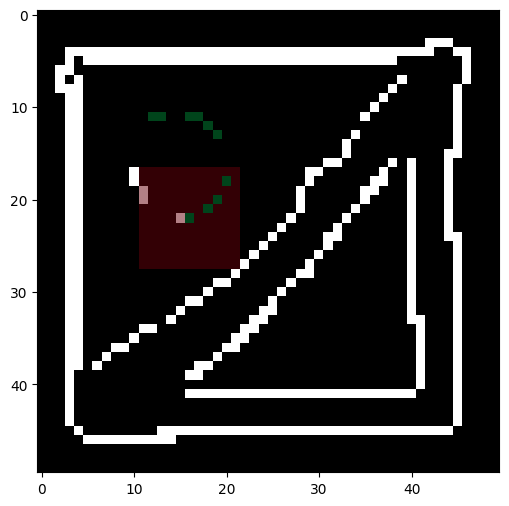

In [442]:
#window(mask, 18, 12, 5))
import matplotlib.cm as cm
curr_cmap = cm.Reds
curr_cmap.set_under('k', alpha=0)
found_cmap = cm.Greens
found_cmap.set_under('k', alpha=0)
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.imshow(mask, "gray")
ax.imshow(window_mask(mask, (16, 22), 11), curr_cmap, alpha=0.5, clim=[0.9, 1])
ax.imshow(window_mask(mask, (16, 22), 1), curr_cmap, clim=[0.9, 1])
ax.imshow(found_img, found_cmap, clim=[0.9, 1])
plt.show()

In [154]:
import diplib as dip

sk = dip.EuclideanSkeleton(mask.astype(bool), endPixelCondition="three neighbors")
sk

<Scalar image, BIN, sizes {50, 50}>

Found 13 contours
Length average: 8.76923076923077, median: 6.0


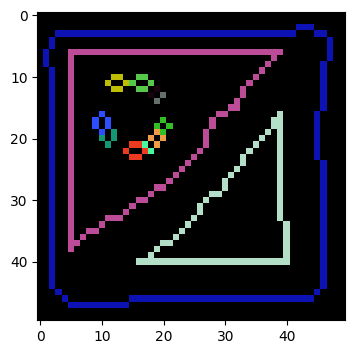

In [141]:
result_fill = np.ones(img.shape, np.uint8) * 255
result_borders = np.zeros(img.shape, np.uint8)

contours = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[0][:-1]
print(f"Found {len(contours)} contours")
lens = [len(contour) for contour in contours]
print(f"Length average: {sum(lens) / len(contours)}, median: {np.median(lens)}")
for contour in contours:
    cv2.drawContours(result_fill, [contour], -1, 0, 1)
    cv2.drawContours(result_borders, [contour], -1, list(np.random.random(size=3) * 256), 1)
# cv2.drawContours(result_fill, contours, -1, 0, -1)
# cv2.drawContours(result_borders, contours, -1, 255, 1)

result = result_fill ^ result_borders

show_image(result_borders, 4)

In [134]:
low_threshold = 50
high_threshold = 150
edges = cv2.Canny(gray, low_threshold, high_threshold)

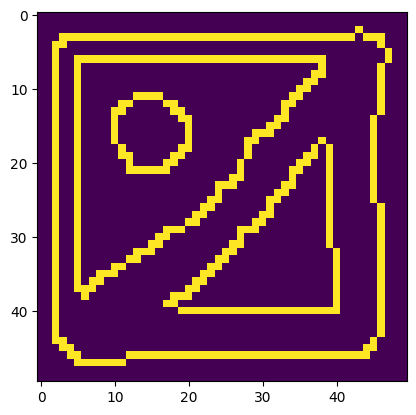

In [135]:
plt.imshow(edges)